# Tutorial: Reduced order models (POD-NN and POD-RBF) for parametric problems

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial9/tutorial.ipynb)

The tutorial aims to show how to employ the **PINA** library in order to apply a reduced order modeling technique [1]. Such methodologies have several similarities with machine learning approaches, since the main goal consists in predicting the solution of differential equations (typically parametric PDEs) in a real-time fashion.

In particular we are going to use the Proper Orthogonal Decomposition with either Radial Basis Function Interpolation (POD-RBF) or Neural Network (POD-NN) [2]. Here we basically perform a dimensional reduction using the POD approach, approximating the parametric solution manifold (at the reduced space) using a regression technique (NN) and comparing it to an RBF interpolation. In this example, we use a simple multilayer perceptron, but the plenty of different architectures can be plugged as well.

#### References
1. Rozza G., Stabile G., Ballarin F. (2022). Advanced Reduced Order Methods and Applications in Computational Fluid Dynamics, Society for Industrial and Applied Mathematics. 
2. Hesthaven, J. S., & Ubbiali, S. (2018). Non-intrusive reduced order modeling of nonlinear problems using neural networks. Journal of Computational Physics, 363, 55-78.

Let's start with the necessary imports.
It's important to note the minimum PINA version to run this tutorial is the `0.1`.

In [1]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"

%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import torch
import pina

from pina.domain import CartesianDomain
from pina.optim import TorchOptimizer
from pina.problem import ParametricProblem
from pina.model.block import PODBlock, RBFBlock
from pina import Condition, LabelTensor, Trainer
from pina.model import FeedForward
from pina.solver import SupervisedSolver

We exploit the [Smithers](https://github.com/mathLab/Smithers) library to collect the parametric snapshots. In particular, we use the `NavierStokesDataset` class that contains a set of parametric solutions of the Navier-Stokes equations in a 2D L-shape domain. The parameter is the inflow velocity.
The dataset is composed by 500 snapshots of the velocity (along $x$, $y$, and the magnitude) and pressure fields, and the corresponding parameter values.

To visually check the snapshots, let's plot also the data points and the reference solution: this is the expected output of our model.

<>: SyntaxWarning: invalid escape sequence '\m'
<>: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_58248/733312969.py: SyntaxWarning: invalid escape sequence '\m'
/usr/lib/python3.12/pty.py: DeprecationWarning: This process (pid=58248) is multi-threaded, use of forkpty() may lead to deadlocks in the child.


error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

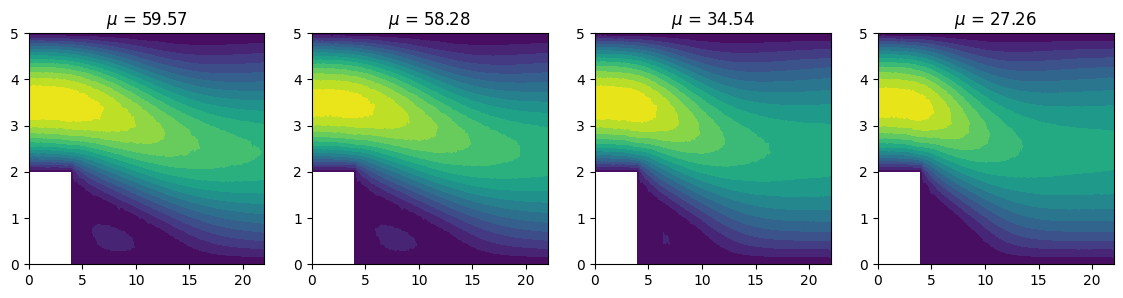

In [2]:
!pip install git+https://github.com/mathLab/Smithers.git
import smithers
from smithers.dataset import NavierStokesDataset
dataset = NavierStokesDataset()

fig, axs = plt.subplots(1, 4, figsize=(14, 3))
for ax, p, u in zip(axs, dataset.params[:4], dataset.snapshots['mag(v)'][:4]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f'$\mu$ = {p[0]:.2f}')

The *snapshots* - aka the numerical solutions computed for several parameters - and the corresponding parameters are the only data we need to train the model, in order to predict the solution for any new test parameter.
To properly validate the accuracy, we initially split the 500 snapshots into the training dataset (90% of the original data) and the testing one (the reamining 10%). It must be said that, to plug the snapshots into **PINA**, we have to cast them to `LabelTensor` objects.

In [3]:
u = torch.tensor(dataset.snapshots['mag(v)']).float()
p = torch.tensor(dataset.params).float()

p = LabelTensor(p, labels=['mu'])
u = LabelTensor(u, labels=[f's{i}' for i in range(u.shape[1])])

ratio_train_test = 0.9
n = u.shape
n_train = int(u.shape[0] * ratio_train_test)
n_test = u - n_train
u_train, u_test = u[:n_train], u[n_train:]
p_train, p_test = p[:n_train], p[n_train:]

It is now time to define the problem! We inherit from `ParametricProblem` (since the space invariant typically of this methodology), just defining a simple *input-output* condition.

In [4]:
class SnapshotProblem(ParametricProblem):
    output_variables = [f's{i}' for i in range(u.shape[1])]
    parameter_domain = CartesianDomain({'mu': [0, 100]})

    conditions = {
        'io': Condition(input_points=p_train, output_points=u_train)
    }

poisson_problem = SnapshotProblem()

We can then build a `POD-NN` model (using an MLP architecture as approximation) and compare it with a `POD-RBF` model (using a Radial Basis Function interpolation as approximation).

## POD-NN reduced order model

Let's build the `PODNN` class

In [5]:
class PODNN(torch.nn.Module):
    """
    Proper orthogonal decomposition with neural network model.
    """
    def __init__(self, pod_rank, layers, func):
        """
        
        """
        super().__init__()
        
        self.pod = PODBlock(pod_rank)
        self.nn = FeedForward(
            input_dimensions=1,
            output_dimensions=pod_rank,
            layers=layers,
            func=func
        )
            

    def forward(self, x):
        """
        Defines the computation performed at every call.

        :param x: The tensor to apply the forward pass.
        :type x: torch.Tensor
        :return: the output computed by the model.
        :rtype: torch.Tensor
        """
        coefficents = self.nn(x)
        return self.pod.expand(coefficents)

    def fit_pod(self, x):
        """
        Just call the :meth:`pina.model.layers.PODBlock.fit` method of the
        :attr:`pina.model.layers.PODBlock` attribute.
        """
        self.pod.fit(x)

We highlight that the POD modes are directly computed by means of the singular value decomposition (computed over the input data), and not trained using the backpropagation approach. Only the weights of the MLP are actually trained during the optimization loop.

In [6]:
pod_nn = PODNN(pod_rank=20, layers=[10, 10, 10], func=torch.nn.Tanh)
pod_nn.fit_pod(u_train)

pod_nn_stokes = SupervisedSolver(
    problem=poisson_problem, 
    model=pod_nn, 
    optimizer=TorchOptimizer(torch.optim.Adam))

Now that we have set the `Problem` and the `Model`, we have just to train the model and use it for predicting the test snapshots.

In [7]:
trainer = Trainer(
    solver=pod_nn_stokes,
    max_epochs=1000,
    batch_size=100,
    log_every_n_steps=5,
    accelerator='cpu')
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | _pina_models | ModuleList | 460    | train
1 | _loss        | MSELoss    | 0      | train
----------------------------------------------------
460       Trainable params
0         Non-trainable params
460       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


/home/matte_b/.local/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 40.25it/s, v_num=14, io_loss_step=0.0913, train_loss_step=0.0695, val_loss_step=0.0913, io_loss_epoch=0.0836, val_loss_epoch=0.0913, train_loss_epoch=0.0836]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 4/4 [00:00<00:00, 36.81it/s, v_num=14, io_loss_step=0.0913, train_loss_step=0.0695, val_loss_step=0.0913, io_loss_epoch=0.0836, val_loss_epoch=0.0913, train_loss_epoch=0.0836]


Done! Now that the computational expensive part is over, we can load in future the model to infer new parameters (simply loading the checkpoint file automatically created by `Lightning`) or test its performances. We measure the relative error for the training and test datasets, printing the mean one.

In [8]:
u_test_nn = pod_nn_stokes(p_test)
u_train_nn = pod_nn_stokes(p_train)

relative_error_train = torch.norm(u_train_nn - u_train)/torch.norm(u_train)
relative_error_test = torch.norm(u_test_nn - u_test)/torch.norm(u_test)

print('Error summary for POD-NN model:')
print(f'  Train: {relative_error_train.item():e}')
print(f'  Test:  {relative_error_test.item():e}')

Error summary for POD-NN model:
  Train: 1.222485e-02
  Test:  1.096203e-02


## POD-RBF reduced order model

Then, we define the model we want to use, with the POD (`PODBlock`) and the RBF (`RBFBlock`) objects.

In [9]:
class PODRBF(torch.nn.Module):
    """
    Proper orthogonal decomposition with Radial Basis Function interpolation model.
    """

    def __init__(self, pod_rank, rbf_kernel):
        """
        
        """
        super().__init__()
        
        self.pod = PODBlock(pod_rank)
        self.rbf = RBFBlock(kernel=rbf_kernel)
            

    def forward(self, x):
        """
        Defines the computation performed at every call.

        :param x: The tensor to apply the forward pass.
        :type x: torch.Tensor
        :return: the output computed by the model.
        :rtype: torch.Tensor
        """
        coefficents = self.rbf(x)
        return self.pod.expand(coefficents)

    def fit(self, p, x):
        """
        Call the :meth:`pina.model.layers.PODBlock.fit` method of the
        :attr:`pina.model.layers.PODBlock` attribute to perform the POD,
        and the :meth:`pina.model.layers.RBFBlock.fit` method of the
        :attr:`pina.model.layers.RBFBlock` attribute to fit the interpolation.
        """
        self.pod.fit(x)
        self.rbf.fit(p, self.pod.reduce(x))

We can then fit the model and ask it to predict the required field for unseen values of the parameters. Note that this model does not need a `Trainer` since it does not include any neural network or learnable parameters.

In [10]:
pod_rbf = PODRBF(pod_rank=20, rbf_kernel='thin_plate_spline')
pod_rbf.fit(p_train, u_train)

In [11]:
u_test_rbf = pod_rbf(p_test)
u_train_rbf = pod_rbf(p_train)

relative_error_train = torch.norm(u_train_rbf - u_train)/torch.norm(u_train)
relative_error_test = torch.norm(u_test_rbf - u_test)/torch.norm(u_test)

print('Error summary for POD-RBF model:')
print(f'  Train: {relative_error_train.item():e}')
print(f'  Test:  {relative_error_test.item():e}')

Error summary for POD-RBF model:
  Train: 1.319915e-04
  Test:  1.171321e-04


## POD-RBF vs POD-NN

We can of course also plot the solutions predicted by the `PODRBF` and by the `PODNN` model, comparing them to the original ones. We can note here, in the `PODNN` model and for low velocities, some differences, but improvements can be accomplished thanks to longer training.

<>: SyntaxWarning: invalid escape sequence '\m'
<>: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_58248/1123744610.py: SyntaxWarning: invalid escape sequence '\m'


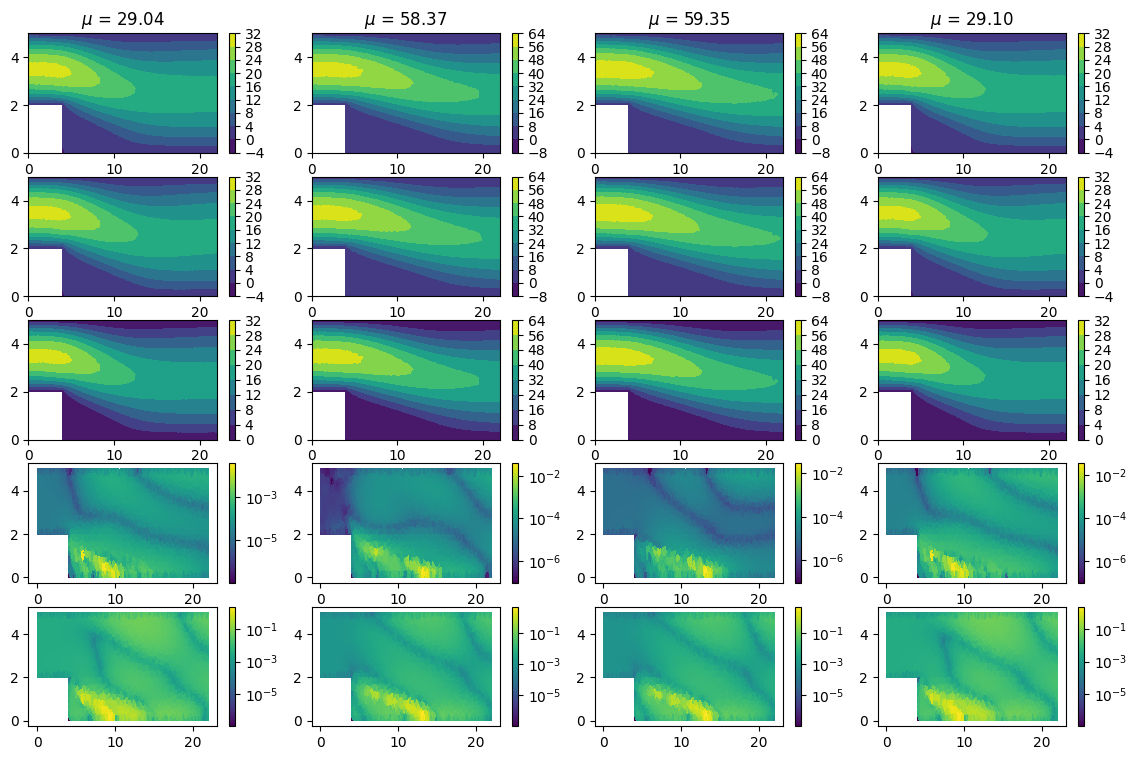

In [12]:
idx = torch.randint(0, len(u_test), (4,))
u_idx_rbf = pod_rbf(p_test[idx])
u_idx_nn = pod_nn_stokes(p_test[idx])

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 4, figsize=(14, 9))

relative_error_rbf = np.abs(u_test[idx] - u_idx_rbf.detach())
relative_error_rbf = np.where(u_test[idx] < 1e-7, 1e-7, relative_error_rbf/u_test[idx])

relative_error_nn = np.abs(u_test[idx] - u_idx_nn.detach())
relative_error_nn = np.where(u_test[idx] < 1e-7, 1e-7, relative_error_nn/u_test[idx])
                        
for i, (idx_, rbf_, nn_, rbf_err_, nn_err_) in enumerate(
    zip(idx, u_idx_rbf, u_idx_nn, relative_error_rbf, relative_error_nn)):
    axs[0, i].set_title(f'$\mu$ = {p_test[idx_].item():.2f}')
    
    cm = axs[0, i].tricontourf(dataset.triang, rbf_.detach()) # POD-RBF prediction
    plt.colorbar(cm, ax=axs[0, i])
    
    cm = axs[1, i].tricontourf(dataset.triang, nn_.detach()) # POD-NN prediction
    plt.colorbar(cm, ax=axs[1, i])

    cm = axs[2, i].tricontourf(dataset.triang, u_test[idx_].flatten()) # Truth
    plt.colorbar(cm, ax=axs[2, i])

    cm = axs[3, i].tripcolor(dataset.triang, rbf_err_, norm=matplotlib.colors.LogNorm()) # Error for POD-RBF
    plt.colorbar(cm, ax=axs[3, i])
    
    cm = axs[4, i].tripcolor(dataset.triang, nn_err_, norm=matplotlib.colors.LogNorm()) # Error for POD-NN
    plt.colorbar(cm, ax=axs[4, i])
    
plt.show()